In [1]:
# Cell 2: Import libraries
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm.notebook import tqdm

2025-11-27 10:17:08.959693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764235029.056651   41183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764235029.082298   41183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764235029.301475   41183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764235029.301513   41183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764235029.301516   41183 computation_placer.cc:177] computation placer alr

In [2]:
# Cell 3: Load the model
print("Loading model...")
processor = AutoImageProcessor.from_pretrained("chriamue/bird-species-classifier")
model = AutoModelForImageClassification.from_pretrained("chriamue/bird-species-classifier")
model.eval()
print("Model loaded successfully!")

Loading model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully!


In [3]:
# Cell 4: Define helper functions
def predict_bird_species(image_path, processor, model):
    """
    Predict bird species from an image file
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    
    # Prepare image for the model
    inputs = processor(images=image, return_tensors="pt")
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get top 3 predictions
    top_indices = torch.topk(probs, k=3).indices[0].tolist()
    top_probs = torch.topk(probs, k=3).values[0].tolist()
    
    # Get predicted labels
    predicted_labels = [model.config.id2label[idx] for idx in top_indices]
    
    return predicted_labels, top_probs

def display_prediction(image_path, labels, confidences):
    """Display image with predictions and confidences"""
    image = Image.open(image_path)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    
    # Create title with predictions
    title = "Predictions:\n"
    for i in range(len(labels)):
        title += f"{i+1}. {labels[i]}: {confidences[i]:.1%}\n"
        
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
# Cell 5: Find images in dataset
# Update this path to your dataset location
dataset_path = "/home/c-enjalbert/.cache/kagglehub/datasets/kedarsai/bird-species-classification-220-categories/versions/1"

# Check if path exists
if not os.path.exists(dataset_path):
    print(f"Dataset path not found: {dataset_path}")
else:
    # Find all images
    image_files = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))
    
    print(f"Found {len(image_files)} images")

Dataset path not found: /home/c-enjalbert/.cache/kagglehub/datasets/kedarsai/bird-species-classification-220-categories/versions/1


In [6]:
### Cell 6: Analyze a few random images
##num_samples = 3  # Change this to classify more images
##
##if len(image_files) > num_samples:
##    sample_images = random.sample(image_files, num_samples)
##else:
##    sample_images = image_files
##
##for img_path in sample_images:
##    try:
##        # Get directory name as potential ground truth
##        dir_name = os.path.basename(os.path.dirname(img_path))
##        print(f"Image: {os.path.basename(img_path)}")
##        print(f"Directory: {dir_name}")
##        
##        # Predict species
##        labels, confidences = predict_bird_species(img_path, processor, model)
##        
##        # Display
##        display_prediction(img_path, labels, confidences)
##        
##    except Exception as e:
##        print(f"Error processing {img_path}: {e}")

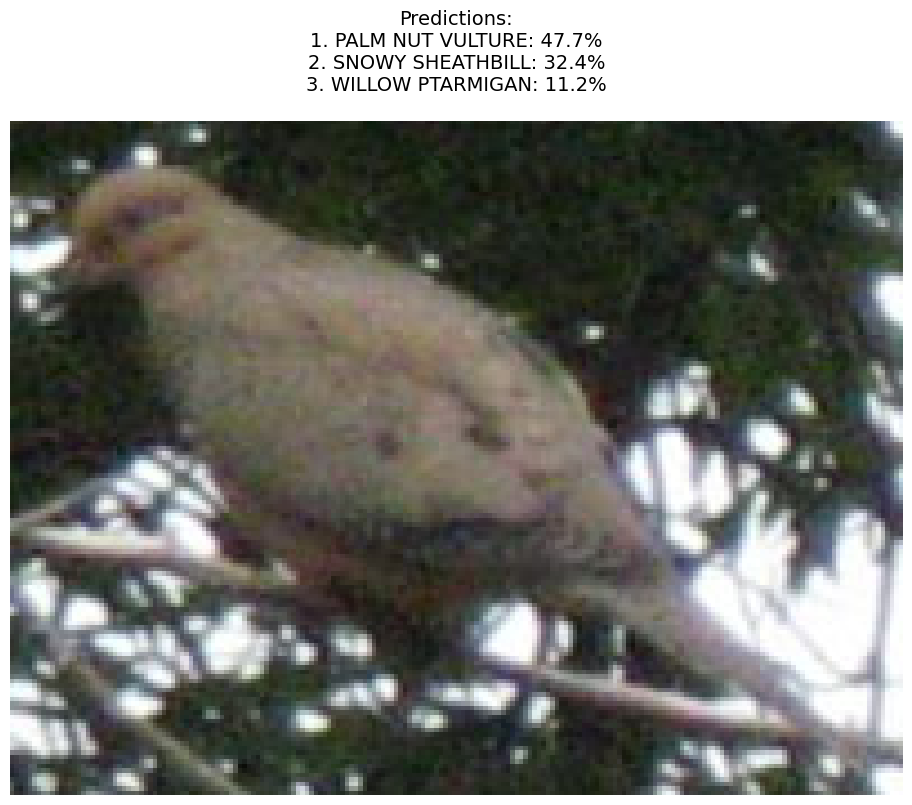

In [7]:
# Cell 7: Classify your own image
# Replace with the path to your own bird image
your_image_path = "/home/c-enjalbert/Documents/EPSI/OpenInnovation/Peekabo/research_ml/external_data/bird6.jpg"

# Check if file exists
if os.path.exists(your_image_path):
    labels, confidences = predict_bird_species(your_image_path, processor, model)
    display_prediction(your_image_path, labels, confidences)
else:
    print(f"Image not found: {your_image_path}")

In [8]:
# Cell 8: Batch processing (optional for larger datasets)
def batch_process(image_paths, batch_size=50):
    """Process images in smaller batches to avoid memory issues"""
    results = []
    
    # Process in batches
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = image_paths[i:i+batch_size]
        
        for img_path in batch:
            try:
                labels, confidences = predict_bird_species(img_path, processor, model)
                
                results.append({
                    'path': img_path,
                    'directory': os.path.basename(os.path.dirname(img_path)),
                    'top_prediction': labels[0],
                    'confidence': confidences[0]
                })
            except Exception as e:
                print(f"Error with {img_path}: {e}")
    
    return results

# Uncomment to run batch processing on a larger set of images
# subset = random.sample(image_files, min(100, len(image_files)))
# results = batch_process(subset)
# 
# # Check accuracy if directory names match species
# correct = sum(1 for r in results if r['top_prediction'].lower() in r['directory'].lower())
# print(f"Matched predictions: {correct}/{len(results)} ({correct/len(results):.1%})")